In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno
from prophet.plot import plot_plotly, plot_components_plotly

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
#from pmdarima.arima import CHTest, nsdiffs
#from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
#import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline
from prophet import Prophet

import os

import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

C:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Methods to support

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics


In [23]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [4]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'Feature Engineering'

# Prophet Model w/ family cat

In [ ]:
df_test_p = pd.read_pickle(path / 'df_test_fb.pkl')
df_train_p = pd.read_pickle(path / 'df_train_fb.pkl')

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'family' column
df_train_p['family_enc'] = label_encoder.fit_transform(df_train_p['family'])
df_test_p['family_enc'] = label_encoder.fit_transform(df_test_p['family'])

model_df = df_train_p[['date', 'sales', 'family_enc']]
model_df.columns = ['ds', 'y', 'family_enc']
model_df['ds'] = pd.to_datetime(model_df['ds'])

model_df_test = df_test_p[['date', 'sales', 'family_enc']]
model_df_test.columns = ['ds', 'y', 'family_enc']
model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

In [8]:
m = Prophet()
m.add_regressor('family_enc')
m.fit(model_df)

forecast = m.predict(model_df_test.drop(columns="y"))

evaluate_forecast(model_df_test['y'], forecast['yhat'])

16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing


* RMSLE - 3.72
* Features - Timestamp, Family (Encoded w/ Label Encoder)

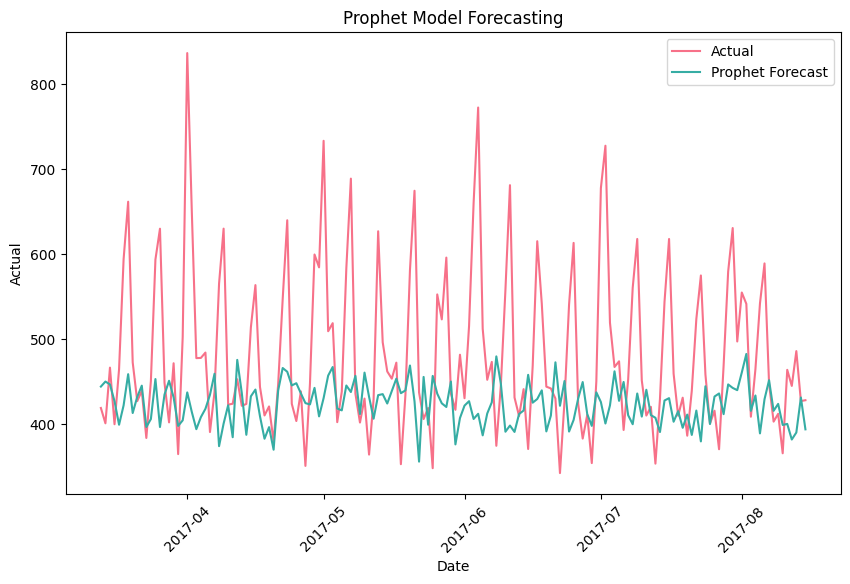

In [24]:
plot_predictions(model_df_test['ds'], model_df_test['y'], forecast['yhat'], 'Prophet Forecast', 'Prophet Model Forecasting')

# Prophet Model w/ all one hot encoded features

In [11]:
df_test_all = pd.read_pickle(path / 'df_test.pkl')
df_train_all = pd.read_pickle(path / 'df_train.pkl')

In [48]:
df_test_all.columns

Index(['date', 'sales', 'onpromotion', 'day_of_week', 'month', 'year',
       'oil_price', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14',
       'cluster_15', 'cluster_16', 'cluster_17', 'holiday_Carnaval',
       'holiday_Dia de la Madre', 'holiday_Dia del Trabajo',
       'holiday_Fundacion de Quito', 'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano', 'familycluster_0',
       'familycluster_1', 'familycluster_2', 'familycluster_3',
       'familycluster_4', '

In [12]:
model_df_all = df_train_all
model_df_test_all = df_test_all
model_df_all.rename(columns = {'date':'ds'}, inplace = True)
model_df_all.rename(columns = {'sales':'y'}, inplace = True)
model_df_all['ds'] = pd.to_datetime(model_df_all['ds'])
model_df_test_all.rename(columns = {'date':'ds'}, inplace = True)
model_df_test_all.rename(columns = {'sales':'y'}, inplace = True)
model_df_test_all['ds'] = pd.to_datetime(model_df_test_all['ds'])

In [13]:
model_df_all

,ds,y,onpromotion,day_of_week,month,year,oil_price,cluster_1,cluster_2,cluster_3,...,holiday_Terremoto Manabi+3,holiday_Terremoto Manabi+4,holiday_Terremoto Manabi+5,holiday_Traslado Primer dia del ano,familycluster_0,familycluster_1,familycluster_2,familycluster_3,familycluster_4,familycluster_5
844600,2013-01-01,0.000,0.000000,0.166667,0.000000,0.00,0.792965,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
844576,2013-01-01,186.000,0.000000,0.166667,0.000000,0.00,0.792965,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
844577,2013-01-01,143.000,0.000000,0.166667,0.000000,0.00,0.792965,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
844578,2013-01-01,71.090,0.000000,0.166667,0.000000,0.00,0.792965,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
844579,2013-01-01,46.000,0.000000,0.166667,0.000000,0.00,0.792965,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990714,2016-10-03,214.000,0.000000,0.000000,0.818182,0.75,0.267796,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1990715,2016-10-03,13.000,0.000000,0.000000,0.818182,0.75,0.267796,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1990716,2016-10-03,786.588,0.001350,0.000000,0.818182,0.75,0.267796,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1990717,2016-10-03,610.000,0.012146,0.000000,0.818182,0.75,0.267796,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
c = Prophet()
for i in model_df_all.drop(columns = ['ds', 'y']).columns:
    c.add_regressor(i)
c.fit(model_df_all)

KeyboardInterrupt: 

In [62]:
forecast = c.predict(model_df_test_all.drop(columns="y"))

In [64]:
evaluate_forecast(model_df_test_all['y'], forecast['yhat'])

{'MSE': 9240871.102214858,
 'RMSE': 3039.8801131319074,
 'RMSLE': 7.29259899659889}

# Prophet Model w/ family cat and store sales

In [5]:
df_test_p = pd.read_pickle(path / 'df_test_fb.pkl')
df_train_p = pd.read_pickle(path / 'df_train_fb.pkl')

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# # Apply label encoding to the 'family' column
# df_train_p['family_enc'] = label_encoder.fit_transform(df_train_p['family'])
# df_test_p['family_enc'] = label_encoder.fit_transform(df_test_p['family'])

model_df = df_train_p[['date', 'sales', 'family', 'store_nbr']]
model_df.columns = ['ds', 'y', 'family', 'store_nbr']
model_df['ds'] = pd.to_datetime(model_df['ds'])

model_df_test = df_test_p[['date', 'sales', 'family', 'store_nbr']]
model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

In [40]:
m = Prophet()
for i in model_df.drop(columns = ['ds', 'y']).columns:
    print(i)
    m.add_regressor(i)
m.fit(model_df)

forecast = m.predict(model_df_test.drop(columns="y"))

evaluate_forecast(model_df_test['y'], forecast['yhat'])

family
store_nbr


ValueError: Unable to parse string "SCHOOL AND OFFICE SUPPLIES" at position 0

In [45]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming df_train_p and df_test_p are already loaded

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'family' column
df_train_p['family_enc'] = label_encoder.fit_transform(df_train_p['family'])
df_test_p['family_enc'] = label_encoder.transform(df_test_p['family'])

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = {}
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

        m = Prophet()
        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        results[family] = evaluate_forecast(model_df_test['y'], forecast['yhat'])
    
    return results

# Define your evaluate_forecast function here

# Call the function to train and evaluate Prophet models for each family
results_by_family = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use results_by_family as needed


Processing family: SCHOOL AND OFFICE SUPPLIES


18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing family: CLEANING


18:15:51 - cmdstanpy - INFO - Chain [1] start processing
18:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing family: DAIRY


18:16:05 - cmdstanpy - INFO - Chain [1] start processing
18:16:35 - cmdstanpy - INFO - Chain [1] done processing


Processing family: DELI


18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing family: EGGS


18:17:00 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing


Processing family: FROZEN FOODS


18:17:12 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing


Processing family: GROCERY I


18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:44 - cmdstanpy - INFO - Chain [1] done processing


Processing family: GROCERY II


18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing family: HARDWARE


18:18:03 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing


Processing family: HOME AND KITCHEN I


18:18:21 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing


Processing family: HOME AND KITCHEN II


18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:06 - cmdstanpy - INFO - Chain [1] done processing


Processing family: HOME APPLIANCES


18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing family: HOME CARE


18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing family: LADIESWEAR


18:20:41 - cmdstanpy - INFO - Chain [1] start processing
18:21:05 - cmdstanpy - INFO - Chain [1] done processing


Processing family: LAWN AND GARDEN


18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:22 - cmdstanpy - INFO - Chain [1] done processing


Processing family: LINGERIE


18:21:28 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing family: LIQUOR,WINE,BEER


18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:57 - cmdstanpy - INFO - Chain [1] done processing


Processing family: MAGAZINES


18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing


Processing family: MEATS


18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1] done processing


Processing family: PERSONAL CARE


18:22:35 - cmdstanpy - INFO - Chain [1] start processing
18:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing family: PET SUPPLIES


18:22:49 - cmdstanpy - INFO - Chain [1] start processing
18:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing family: PLAYERS AND ELECTRONICS


18:23:16 - cmdstanpy - INFO - Chain [1] start processing
18:23:49 - cmdstanpy - INFO - Chain [1] done processing


Processing family: POULTRY


18:23:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing


Processing family: PREPARED FOODS


18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing


Processing family: CELEBRATION


18:24:26 - cmdstanpy - INFO - Chain [1] start processing
18:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing family: BREAD/BAKERY


18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing family: BOOKS
Processing family: BEVERAGES


18:25:18 - cmdstanpy - INFO - Chain [1] start processing
18:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing family: SEAFOOD


18:25:46 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing family: AUTOMOTIVE


18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:11 - cmdstanpy - INFO - Chain [1] done processing


Processing family: PRODUCE


18:26:18 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing


Processing family: BEAUTY


18:26:53 - cmdstanpy - INFO - Chain [1] start processing
18:27:10 - cmdstanpy - INFO - Chain [1] done processing


Processing family: BABY CARE


18:27:16 - cmdstanpy - INFO - Chain [1] start processing
18:27:26 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
results_by_family

{'SCHOOL AND OFFICE SUPPLIES': {'MSE': 3208.732049826798,
  'RMSE': 56.645671059903584,
  'RMSLE': 2.077286072781716},
 'CLEANING': {'MSE': 610178.6620919813,
  'RMSE': 781.1393359010806,
  'RMSLE': 0.551469246088076},
 'DAIRY': {'MSE': 484642.5824971197,
  'RMSE': 696.1627557526471,
  'RMSLE': 0.7540447155589624},
 'DELI': {'MSE': 44555.3651575138,
  'RMSE': 211.08141831415148,
  'RMSLE': 0.6030025593245224},
 'EGGS': {'MSE': 28500.172487267246,
  'RMSE': 168.81994102376427,
  'RMSLE': 0.8411235768718565},
 'FROZEN FOODS': {'MSE': 15520.543615466719,
  'RMSE': 124.58147380516382,
  'RMSLE': 0.8642499982006029},
 'GROCERY I': {'MSE': 8130248.495389555,
  'RMSE': 2851.35906111271,
  'RMSLE': 0.5431554054331819},
 'GROCERY II': {'MSE': 1144.3653059291216,
  'RMSE': 33.828468867643444,
  'RMSLE': 1.1612166860373785},
 'HARDWARE': {'MSE': 3.8042757805066447,
  'RMSE': 1.950455275187474,
  'RMSLE': 0.6434938320538913},
 'HOME AND KITCHEN I': {'MSE': 831.648113908402,
  'RMSE': 28.8383098309

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = []
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
        results.append((family, rmsle_value, len(test_family)))
    
    # Aggregate the results
    total_samples = sum([sample_count for _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, rmsle, sample_count in results])
    
    return weighted_rmsle

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)


Processing family: SCHOOL AND OFFICE SUPPLIES


ValueError: Capacities must be supplied for logistic growth in column "cap"

In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = []
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])
        
        m = Prophet()
        m.add_country_holidays(country_name='EC')
        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x >= 0 else 0)
        rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
        results.append((family, rmsle_value, len(test_family)))
        print(forecast['yhat'].describe())
    
    # Aggregate the results
    total_samples = sum([sample_count for _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, rmsle, sample_count in results])
    
    return weighted_rmsle, results

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)


Processing family: SCHOOL AND OFFICE SUPPLIES


16:47:15 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        2.049047
std         1.808555
min         0.000000
25%         0.438751
50%         1.731419
75%         3.299620
max         9.125139
Name: yhat, dtype: float64
Processing family: CLEANING


16:47:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:05 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean     1217.145831
std       198.898310
min       888.440764
25%      1076.055345
50%      1128.452605
75%      1461.214020
max      1711.605562
Name: yhat, dtype: float64
Processing family: DAIRY


16:48:13 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      993.403465
std       137.139130
min       788.186773
25%       903.382670
50%       942.218426
75%      1141.817206
max      1266.043509
Name: yhat, dtype: float64
Processing family: DELI


16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:49:00 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      311.464915
std        55.166303
min       243.123889
25%       268.618025
50%       288.816480
75%       365.981081
max       426.885703
Name: yhat, dtype: float64
Processing family: EGGS


16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:17 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      207.619731
std        34.298522
min       164.589238
25%       182.919117
50%       187.122731
75%       233.858714
max       277.004849
Name: yhat, dtype: float64
Processing family: FROZEN FOODS


16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:50 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      104.877495
std        34.303835
min        46.267499
25%        79.067426
50%       101.568286
75%       123.661386
max       187.982884
Name: yhat, dtype: float64
Processing family: GROCERY I


16:49:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean     4567.019258
std       732.039376
min      3400.306278
25%      4011.577008
50%      4293.060801
75%      5258.255297
max      6411.698738
Name: yhat, dtype: float64
Processing family: GROCERY II


16:50:15 - cmdstanpy - INFO - Chain [1] start processing
16:50:24 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean       15.400624
std         3.297458
min         9.612252
25%        13.045736
50%        14.976060
75%        17.043264
max        22.038335
Name: yhat, dtype: float64
Processing family: HARDWARE


16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:50 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        0.802287
std         0.215042
min         0.423304
25%         0.635403
50%         0.736050
75%         1.003659
max         1.313348
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN I


16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:21 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean       39.263836
std         4.607075
min        31.907868
25%        35.914672
50%        38.098382
75%        42.384180
max        53.159588
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN II


16:51:29 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        5.999895
std         3.923011
min         0.000000
25%         2.964255
50%         5.489864
75%         8.948042
max        15.779992
Name: yhat, dtype: float64
Processing family: HOME APPLIANCES


16:52:07 - cmdstanpy - INFO - Chain [1] start processing
16:52:34 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        0.004336
std         0.020869
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.180578
Name: yhat, dtype: float64
Processing family: HOME CARE


16:52:42 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      298.592443
std        41.021264
min       200.615895
25%       266.485296
50%       293.292281
75%       327.590680
max       404.869842
Name: yhat, dtype: float64
Processing family: LADIESWEAR


16:53:34 - cmdstanpy - INFO - Chain [1] start processing
16:54:12 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean       12.462863
std         3.004733
min         7.303251
25%        10.045625
50%        11.786536
75%        14.051287
max        20.207222
Name: yhat, dtype: float64
Processing family: LAWN AND GARDEN


16:54:20 - cmdstanpy - INFO - Chain [1] start processing
16:54:31 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        6.511954
std         1.183484
min         4.564086
25%         5.404839
50%         6.780017
75%         7.317933
max         8.961950
Name: yhat, dtype: float64
Processing family: LINGERIE


16:54:38 - cmdstanpy - INFO - Chain [1] start processing
16:54:55 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        6.622852
std         1.357470
min         4.934870
25%         5.471206
50%         6.061909
75%         7.841151
max        10.088310
Name: yhat, dtype: float64
Processing family: LIQUOR,WINE,BEER


16:55:03 - cmdstanpy - INFO - Chain [1] start processing
16:55:10 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean      111.931798
std        56.569051
min        21.857689
25%        79.380066
50%        97.153944
75%       155.940723
max       235.993276
Name: yhat, dtype: float64
Processing family: MAGAZINES


16:55:18 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        6.870154
std         0.669970
min         5.418508
25%         6.316916
50%         6.795784
75%         7.308136
max         8.606056
Name: yhat, dtype: float64
Processing family: MEATS


16:55:45 - cmdstanpy - INFO - Chain [1] start processing
16:55:52 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      346.828266
std        52.099713
min       273.142471
25%       304.308908
50%       316.132487
75%       394.162548
max       444.604255
Name: yhat, dtype: float64
Processing family: PERSONAL CARE


16:56:00 - cmdstanpy - INFO - Chain [1] start processing
16:56:07 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      325.474389
std        71.296050
min       217.572681
25%       270.341126
50%       298.073248
75%       389.462428
max       501.973511
Name: yhat, dtype: float64
Processing family: PET SUPPLIES


16:56:15 - cmdstanpy - INFO - Chain [1] start processing
16:56:49 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        8.665747
std         0.856948
min         6.698186
25%         7.986555
50%         8.493829
75%         9.210962
max        10.806226
Name: yhat, dtype: float64
Processing family: PLAYERS AND ELECTRONICS


16:56:56 - cmdstanpy - INFO - Chain [1] start processing
16:57:32 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        9.107660
std         1.378445
min         6.254314
25%         8.094475
50%         8.709517
75%        10.193168
max        13.018570
Name: yhat, dtype: float64
Processing family: POULTRY


16:57:41 - cmdstanpy - INFO - Chain [1] start processing
16:57:53 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean      415.010907
std        69.635841
min       302.938074
25%       359.059255
50%       377.915916
75%       485.231915
max       537.756354
Name: yhat, dtype: float64
Processing family: PREPARED FOODS


16:58:01 - cmdstanpy - INFO - Chain [1] start processing
16:58:12 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean      103.054075
std        17.479260
min        82.444712
25%        89.465977
50%        95.637199
75%       126.084601
max       135.938844
Name: yhat, dtype: float64
Processing family: CELEBRATION


16:58:19 - cmdstanpy - INFO - Chain [1] start processing
16:58:46 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean       10.907554
std         2.235752
min         6.538544
25%         9.310989
50%        10.529867
75%        12.309693
max        17.884952
Name: yhat, dtype: float64
Processing family: BREAD/BAKERY


16:58:54 - cmdstanpy - INFO - Chain [1] start processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean      595.026071
std        85.031525
min       481.849390
25%       535.576719
50%       557.708196
75%       660.324591
max       783.069180
Name: yhat, dtype: float64
Processing family: BOOKS
count    8380.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: yhat, dtype: float64
Processing family: BEVERAGES


16:59:22 - cmdstanpy - INFO - Chain [1] start processing
16:59:52 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean     2926.237720
std       523.527650
min      1921.258059
25%      2538.753438
50%      2739.519884
75%      3452.381381
max      4118.228640
Name: yhat, dtype: float64
Processing family: SEAFOOD


17:00:00 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean       26.946402
std         4.519920
min        19.063496
25%        22.952559
50%        25.614523
75%        31.160328
max        35.668632
Name: yhat, dtype: float64
Processing family: AUTOMOTIVE


17:00:19 - cmdstanpy - INFO - Chain [1] start processing
17:00:29 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean        5.785476
std         1.496564
min         4.117328
25%         4.682217
50%         4.971557
75%         7.626072
max         9.159810
Name: yhat, dtype: float64
Processing family: PRODUCE


17:00:36 - cmdstanpy - INFO - Chain [1] start processing
17:01:25 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean     2155.286639
std       319.115945
min      1451.973301
25%      1921.924921
50%      2128.947330
75%      2374.331624
max      3010.335196
Name: yhat, dtype: float64
Processing family: BEAUTY


17:01:34 - cmdstanpy - INFO - Chain [1] start processing
17:01:50 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean        6.491071
std         1.076101
min         5.138559
25%         5.639763
50%         6.083426
75%         7.377078
max         9.026598
Name: yhat, dtype: float64
Processing family: BABY CARE


17:01:58 - cmdstanpy - INFO - Chain [1] start processing
17:02:11 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean        0.406376
std         0.022518
min         0.356756
25%         0.389503
50%         0.405880
75%         0.420168
max         0.480233
Name: yhat, dtype: float64
Weighted RMSLE: (0.9042748230926073, [('SCHOOL AND OFFICE SUPPLIES', 1.300003774141835, 8381), ('CLEANING', 0.5504685936494585, 8380), ('DAIRY', 0.7532968384388142, 8381), ('DELI', 0.6026076154096475, 8381), ('EGGS', 0.8410254780367522, 8381), ('FROZEN FOODS', 0.8013912676120768, 8381), ('GROCERY I', 0.5432947722406664, 8381), ('GROCERY II', 1.1588188924980118, 8381), ('HARDWARE', 0.646792700958478, 8382), ('HOME AND KITCHEN I', 0.867260886935071, 8382), ('HOME AND KITCHEN II', 1.7141381270215177, 8382), ('HOME APPLIANCES', 0.5708778277484363, 8381), ('HOME CARE', 0.5845850105622294, 8381), ('LADIESWEAR', 1.5684248454713077, 8381), ('LAWN AND GARDEN', 1.50997303818408, 8382), ('LINGERIE', 0.9027170531891454, 8382), ('LIQUOR,WINE,BEER', 1.2500982690592997, 8382), ('MAGAZINES', 1.1038874358428392

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = []
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])
        
        m = Prophet()
        m.add_country_holidays(country_name='EC')
        m.add_regressor('store_nbr')
        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x >= 0 else 0)
        rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
        results.append((family, rmsle_value, len(test_family)))
        print(forecast['yhat'].describe())
    
    # Aggregate the results
    total_samples = sum([sample_count for _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, rmsle, sample_count in results])
    
    return weighted_rmsle, results

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)


Processing family: SCHOOL AND OFFICE SUPPLIES


17:18:21 - cmdstanpy - INFO - Chain [1] start processing
17:18:49 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        9.094359
std         2.382927
min         2.686949
25%         7.417683
50%         9.046027
75%        10.702291
max        18.744168
Name: yhat, dtype: float64
Processing family: CLEANING


17:18:57 - cmdstanpy - INFO - Chain [1] start processing
17:19:06 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean     1225.484353
std       252.169801
min       633.311993
25%      1026.830008
50%      1214.065199
75%      1381.764103
max      1987.087536
Name: yhat, dtype: float64
Processing family: DAIRY


17:19:14 - cmdstanpy - INFO - Chain [1] start processing
17:19:40 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      996.462929
std       179.547242
min       594.620592
25%       855.476421
50%       988.515586
75%      1108.833527
max      1467.403147
Name: yhat, dtype: float64
Processing family: DELI


17:19:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:02 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      314.068861
std        65.547704
min       185.792902
25%       262.960973
50%       306.000051
75%       355.636654
max       489.822988
Name: yhat, dtype: float64
Processing family: EGGS


17:20:09 - cmdstanpy - INFO - Chain [1] start processing
17:20:20 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      208.787806
std        38.912057
min       134.556819
25%       178.363003
50%       202.963617
75%       237.159242
max       309.545918
Name: yhat, dtype: float64
Processing family: FROZEN FOODS


17:20:28 - cmdstanpy - INFO - Chain [1] start processing
17:20:51 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      102.570814
std        52.318128
min         0.000000
25%        63.106880
50%       101.963594
75%       139.165929
max       254.568933
Name: yhat, dtype: float64
Processing family: GROCERY I


17:20:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:09 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean     4602.124231
std       929.840428
min      2449.114222
25%      3883.631021
50%      4553.038250
75%      5191.822063
max      7405.709990
Name: yhat, dtype: float64
Processing family: GROCERY II


17:21:17 - cmdstanpy - INFO - Chain [1] start processing
17:21:25 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean       16.090840
std         5.424685
min         2.957429
25%        12.012764
50%        16.108873
75%        20.020431
max        30.040636
Name: yhat, dtype: float64
Processing family: HARDWARE


17:21:33 - cmdstanpy - INFO - Chain [1] start processing
17:21:41 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        0.880493
std         0.221531
min         0.412969
25%         0.710771
50%         0.815366
75%         1.061043
max         1.491418
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN I


17:21:49 - cmdstanpy - INFO - Chain [1] start processing
17:22:09 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean       36.862886
std         5.795352
min        23.258257
25%        32.573575
50%        36.494607
75%        40.560934
max        56.745952
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN II


17:22:16 - cmdstanpy - INFO - Chain [1] start processing
17:22:45 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean       13.279211
std         4.961570
min         0.000000
25%         9.575680
50%        13.193885
75%        16.535597
max        28.408588
Name: yhat, dtype: float64
Processing family: HOME APPLIANCES


17:22:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:25 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        0.008427
std         0.034409
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.352038
Name: yhat, dtype: float64
Processing family: HOME CARE


17:23:33 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      299.736227
std        46.144259
min       166.339865
25%       265.872249
50%       296.149127
75%       331.177067
max       442.995901
Name: yhat, dtype: float64
Processing family: LADIESWEAR


17:24:43 - cmdstanpy - INFO - Chain [1] start processing
17:25:16 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean       12.588985
std         3.113442
min         6.043153
25%        10.248277
50%        12.082515
75%        14.529577
max        21.702665
Name: yhat, dtype: float64
Processing family: LAWN AND GARDEN


17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:32 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        6.496941
std         1.228560
min         3.995320
25%         5.390397
50%         6.606421
75%         7.398792
max         9.513428
Name: yhat, dtype: float64
Processing family: LINGERIE


17:25:40 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean        5.941109
std         1.795084
min         2.214927
25%         4.578993
50%         5.863184
75%         7.090563
max        11.480857
Name: yhat, dtype: float64
Processing family: LIQUOR,WINE,BEER


17:26:06 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean      108.267154
std        58.774275
min         0.000000
25%        69.601967
50%        95.797419
75%       143.662896
max       260.078750
Name: yhat, dtype: float64
Processing family: MAGAZINES


17:26:25 - cmdstanpy - INFO - Chain [1] start processing
17:26:47 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        6.883738
std         0.718724
min         5.014742
25%         6.339290
50%         6.825904
75%         7.377176
max         9.063531
Name: yhat, dtype: float64
Processing family: MEATS


17:26:54 - cmdstanpy - INFO - Chain [1] start processing
17:27:02 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      353.483252
std        78.910908
min       177.708861
25%       295.751813
50%       353.297924
75%       405.947645
max       552.427059
Name: yhat, dtype: float64
Processing family: PERSONAL CARE


17:27:10 - cmdstanpy - INFO - Chain [1] start processing
17:27:18 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean      344.253506
std        88.169309
min       147.231014
25%       276.307066
50%       337.176108
75%       399.935267
max       610.256198
Name: yhat, dtype: float64
Processing family: PET SUPPLIES


17:27:26 - cmdstanpy - INFO - Chain [1] start processing
17:27:55 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        8.737142
std         1.292679
min         5.107163
25%         7.783521
50%         8.728200
75%         9.631605
max        12.529529
Name: yhat, dtype: float64
Processing family: PLAYERS AND ELECTRONICS


17:28:03 - cmdstanpy - INFO - Chain [1] start processing
17:28:42 - cmdstanpy - INFO - Chain [1] done processing


count    8381.000000
mean        9.175465
std         1.888990
min         4.157115
25%         7.751952
50%         9.141610
75%        10.416949
max        15.340785
Name: yhat, dtype: float64
Processing family: POULTRY


17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:58 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean      428.684139
std        86.147505
min       230.637671
25%       360.736843
50%       425.168701
75%       489.428143
max       637.832645
Name: yhat, dtype: float64
Processing family: PREPARED FOODS


17:29:06 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean      103.649658
std        25.308676
min        51.908399
25%        83.648010
50%       103.694532
75%       119.844099
max       167.973820
Name: yhat, dtype: float64
Processing family: CELEBRATION


17:29:22 - cmdstanpy - INFO - Chain [1] start processing
17:29:43 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean       11.474594
std         2.401055
min         5.810964
25%         9.696234
50%        11.140065
75%        13.021330
max        19.610368
Name: yhat, dtype: float64
Processing family: BREAD/BAKERY


17:29:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean      593.113529
std       114.976889
min       349.258942
25%       504.512204
50%       587.021915
75%       664.961865
max       912.813598
Name: yhat, dtype: float64
Processing family: BOOKS
count    8380.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: yhat, dtype: float64
Processing family: BEVERAGES


17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean     2867.680996
std       633.265102
min      1264.270926
25%      2377.291086
50%      2809.317715
75%      3270.041492
max      4673.379929
Name: yhat, dtype: float64
Processing family: SEAFOOD


17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing


count    8382.000000
mean       27.119197
std         5.955793
min        12.641586
25%        22.665378
50%        27.092284
75%        31.260849
max        42.516557
Name: yhat, dtype: float64
Processing family: AUTOMOTIVE


17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean        5.837159
std         2.167682
min         1.494520
25%         4.112389
50%         5.830150
75%         7.204052
max        11.909934
Name: yhat, dtype: float64
Processing family: PRODUCE


17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean     2143.511432
std       377.133670
min      1098.498413
25%      1875.175540
50%      2134.871403
75%      2401.950644
max      3339.518769
Name: yhat, dtype: float64
Processing family: BEAUTY


17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean        6.568182
std         1.292035
min         4.004003
25%         5.573009
50%         6.419292
75%         7.390881
max        10.328101
Name: yhat, dtype: float64
Processing family: BABY CARE


17:32:38 - cmdstanpy - INFO - Chain [1] start processing
17:32:48 - cmdstanpy - INFO - Chain [1] done processing


count    8380.000000
mean        0.380650
std         0.029195
min         0.297020
25%         0.360092
50%         0.380455
75%         0.400837
max         0.477111
Name: yhat, dtype: float64
Weighted RMSLE: (0.9174741425006451, [('SCHOOL AND OFFICE SUPPLIES', 1.7877319971633818, 8381), ('CLEANING', 0.5676018163522992, 8380), ('DAIRY', 0.7628773799043962, 8381), ('DELI', 0.6150393027771889, 8381), ('EGGS', 0.848275668687681, 8381), ('FROZEN FOODS', 1.1259777513086444, 8381), ('GROCERY I', 0.5609666573631478, 8381), ('GROCERY II', 1.198587132687644, 8381), ('HARDWARE', 0.6415844711191331, 8382), ('HOME AND KITCHEN I', 0.8377143095298382, 8382), ('HOME AND KITCHEN II', 1.0132167699331551, 8382), ('HOME APPLIANCES', 0.5687433906532385, 8381), ('HOME CARE', 0.5899880501913409, 8381), ('LADIESWEAR', 1.573577633975057, 8381), ('LAWN AND GARDEN', 1.5101248582462912, 8382), ('LINGERIE', 0.8954176921817915, 8382), ('LIQUOR,WINE,BEER', 1.3113364927316256, 8382), ('MAGAZINES', 1.10474338945271

In [22]:
df_train_p[df_train_p['family'] == "SCHOOL AND OFFICE SUPPLIES"].describe()

,sales,familycluster,store_nbr
count,67049.000000,67049.0,67049.000000
mean,2.225999,5.0,26.857940
std,14.913792,0.0,15.641041
min,0.000000,5.0,1.000000
25%,0.000000,5.0,13.000000
50%,0.000000,5.0,27.000000
75%,0.000000,5.0,40.000000
max,1217.000000,5.0,54.000000
